<a href="https://colab.research.google.com/github/Nyamadie/Loss-analysis/blob/main/Information_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
!pip install dash plotly scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3


# Import Data#

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import files
uploaded = files.upload()

Saving patient_data (11).csv to patient_data (11).csv


# Load Data

In [ ]:
from google.colab import userdata
userdata.get[('pickle_file_path'), ('meta_file_path')]

In [5]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import numpy as np
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle
import collections

app = dash.Dash(__name__)

# Load and preprocess data
def load_data(pickle_file_path, meta_file_path, patient_data_path):
    with open(pickle_file_path, 'rb') as file:
        signal_data = pickle.load(file)

    meta_df = pd.read_excel(meta_file_path)
    df = pd.read_csv(patient_data_path)

    filtered_df = df[df['Data QA'] >= 0.4]
    filtered_df = filtered_df.dropna(subset=['z_score'])
    filtered_df['Signal Quality'] = filtered_df['z_score'].apply(lambda x: 'Worst' if x > 0 else 'Best')

    ppg_signals_df = signal_data['file_data']
    worst_signals = filtered_df[filtered_df['Signal Quality'] == 'Worst']['filenames'].tolist()
    best_signals = filtered_df[filtered_df['Signal Quality'] == 'Best']['filenames'].tolist()

    return ppg_signals_df, worst_signals, best_signals, filtered_df

# Load your data
pickle_file_path = ""
meta_file_path = ''
patient_data_path = 'patient_data (11).csv'

ppg_signals_df, worst_signals, best_signals, filtered_df = load_data(
    pickle_file_path, meta_file_path, patient_data_path)

In [6]:
def normalize_signal(signal):
    if len(signal) > 0:
        return (signal - np.mean(signal)) / np.std(signal)
    else:
        return signal

# Statiscal Computation

In [2]:
def compare_all_channels(ppg_signals_df, filenames):
    all_channels = list(next(iter(ppg_signals_df.values())).keys())  # Extract channel names

    # Remove 'Category' and 'raw_data' from the list
    if 'Category' in all_channels:
        all_channels.remove('Category')
    if 'raw_data' in all_channels:
        all_channels.remove('raw_data')

    metrics = {'filename': [], 'channel': [], 'MSE': [], 'Correlation': [], 'Mutual_Information': []}

    for filename in filenames:
        try:
            raw_signal = normalize_signal(ppg_signals_df[filename]['raw_data'])

            for channel in all_channels:
                derived_signal = normalize_signal(ppg_signals_df[filename][channel])

                mse = mean_squared_error(raw_signal, derived_signal)
                corr, _ = pearsonr(raw_signal, derived_signal)
                mi = mutual_info_regression(raw_signal.values.reshape(-1, 1), derived_signal.values)[0]

                metrics['filename'].append(filename)
                metrics['channel'].append(channel)
                metrics['MSE'].append(mse)
                metrics['Correlation'].append(corr)
                metrics['Mutual_Information'].append(mi)

        except KeyError:
            print(f"File {filename} or raw_data channel not found in PPG signals.")
        except ValueError:
            print(f"Signal lengths mismatch for {filename}.")

    return pd.DataFrame(metrics)


In [ ]:
all_channels = list(next(iter(ppg_signals_df.values())).keys())
all_channels

## Visualization

In [21]:
def create_dashboard(metrics_df):
    import dash
    from dash import dcc, html
    import plotly.express as px

    app = dash.Dash(__name__)

    app.layout = html.Div([
        html.H1("Channel Comparison Metrics", style={'textAlign': 'center'}),
        dcc.Graph(
            id='comparison-metrics',
            figure=px.scatter(
                metrics_df,
                x='Correlation',
                y='MSE',
                color='channel',
                size='Mutual_Information',
                hover_data=['filename'],
                title="Comparison Metrics for All Channels Against Raw Data"
            )
        ),
        dcc.Graph(
            id='mutual-info-heatmap',
            figure=px.box(
                metrics_df,
                x='channel',
                y='Mutual_Information',
                color='channel',
                title="Mutual Information Across Channels"
            )
        )
    ])
    app.run_server(debug=True, use_reloader=False)

In [23]:
metrics_df = compare_all_channels(ppg_signals_df, worst_signals + best_signals)

create_dashboard(metrics_df)

<IPython.core.display.Javascript object>

## Aggregation

In [63]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_regression

def calculate_info_loss(ppg_signals_df, filenames):
    all_channels = list(next(iter(ppg_signals_df.values())).keys())  # Extract channel names

    # Removing the 'Category' and 'raw_data' from the list
    if 'Category' in all_channels:
        all_channels.remove('Category')
    if 'raw_data' in all_channels:
        all_channels.remove('raw_data')

    info_loss_metrics = {'filename': [], 'channel': [], 'MSE': [], 'Correlation': [], 'Mutual_Information': [], 'Information_Loss': []}

    for filename in filenames:
        try:
            raw_signal = normalize_signal(ppg_signals_df[filename]['raw_data'])

            for channel in all_channels:
                derived_signal = normalize_signal(ppg_signals_df[filename][channel])

                # Calculate the metrics
                mse = mean_squared_error(raw_signal, derived_signal)
                corr, _ = pearsonr(raw_signal, derived_signal)
                mi = mutual_info_regression(raw_signal.values.reshape(-1, 1), derived_signal.values)[0]

                # Higher MSE or lower correlation/MI would imply higher information loss
                info_loss = mse + (1 - corr) + (1 - mi)  # a simple loss function

                # Store the results
                info_loss_metrics['filename'].append(filename)
                info_loss_metrics['channel'].append(channel)
                info_loss_metrics['MSE'].append(mse)
                info_loss_metrics['Correlation'].append(corr)
                info_loss_metrics['Mutual_Information'].append(mi)
                info_loss_metrics['Information_Loss'].append(info_loss)

        except KeyError:
            print(f"File {filename} or raw_data channel not found in PPG signals.")
        except ValueError:
            print(f"Signal lengths mismatch for {filename}.")

    # Convert metrics to DataFrame
    loss_df = pd.DataFrame(info_loss_metrics)

    # Aggregate the information loss for each filename and channel
    aggregated_loss = loss_df.groupby(['filename', 'channel'])['Information_Loss'].mean().reset_index()

    # Create a new 'Information_Loss' channel in the original signals dataframe
    for filename in filenames:
        # Add the information loss to the ppg_signals_df as a new channel
        info_loss_values = []
        for channel in all_channels:
            loss_value = aggregated_loss[(aggregated_loss['filename'] == filename) &
                                         (aggregated_loss['channel'] == channel)]['Information_Loss'].values
            info_loss_values.append(loss_value[0] if loss_value.size > 0 else np.nan)

        ppg_signals_df[filename]['information_loss'] = np.mean(info_loss_values)

    return ppg_signals_df, aggregated_loss

ppg_signals_df, aggregated_loss = calculate_info_loss(ppg_signals_df, worst_signals + best_signals)

Signal lengths mismatch for AA 05.28.21.2.csv.
Signal lengths mismatch for AG 07.06.21.1.csv.
Signal lengths mismatch for AG 07.06.21.2.csv.
Signal lengths mismatch for AG 07.06.21.3.csv.
Signal lengths mismatch for AL 01.21.21.3.csv.
Signal lengths mismatch for AL 01.21.21.2.csv.
Signal lengths mismatch for AM 06.08.21.2.csv.
Signal lengths mismatch for AM 06.08.21.3.csv.
Signal lengths mismatch for BHRT AS1 10.20.21.2.csv.
Signal lengths mismatch for BHRT AS1 10.20.21.3.csv.
Signal lengths mismatch for BHRT KH1 09.15.21.3.csv.
Signal lengths mismatch for BHRT KH1 09.15.21.1.csv.
Signal lengths mismatch for BHRT KH1 09.15.21.2.csv.
Signal lengths mismatch for BHRT KH1 10.06.21.1.csv.
Signal lengths mismatch for BHRT KH1 10.06.21.3.csv.
Signal lengths mismatch for BHRT KH1 10.06.21.2.csv.
Signal lengths mismatch for BHRT KR1 09.29.21.2.csv.
Signal lengths mismatch for BHRT ML1 09.15.21.1.csv.
Signal lengths mismatch for BHRT ML1 09.15.21.2.csv.
Signal lengths mismatch for BHRT MT1 10.2

In [62]:
ppg_signals_df

{'JFHC GY1 10.12.21.1.csv':       raw_data  Category  raw_10hz_filt  cycle_10hz_filt  trend_10hz_filt  \
 0        20139  Baseline   20139.041583       -16.057309     20155.098892   
 1        20146  Baseline   20146.018734       -10.690851     20156.709585   
 2        20151  Baseline   20150.968353        -7.350320     20158.318673   
 3        20157  Baseline   20156.962106        -2.961374     20159.923480   
 4        20159  Baseline   20159.009504        -2.511093     20161.520597   
 ...        ...       ...            ...              ...              ...   
 2753     20158  Recovery   20158.234588        -1.596811     20159.831399   
 2754     20146  Recovery   20146.217640       -13.007907     20159.225547   
 2755     20143  Recovery   20142.903659       -15.707055     20158.610714   
 2756     20142  Recovery   20141.720658       -16.270584     20157.991242   
 2757     20146  Recovery   20145.921523       -11.448682     20157.370205   
 
       cycle_norm_10hz_filt  fund_f

In [64]:
aggregated_loss.head()

filename               channel  Information_Loss
0  AA 05.28.21.2.csv              af_trend         -0.388964
1  AA 05.28.21.2.csv                 cycle          4.243888
2  AA 05.28.21.2.csv       cycle_10hz_filt          2.473597
3  AA 05.28.21.2.csv            cycle_norm          4.245208
4  AA 05.28.21.2.csv  cycle_norm_10hz_filt          2.473975

In [68]:
specific_loss = aggregated_loss[aggregated_loss['channel'] == 'roll_hr']  # Example: Filter by 'cycle' channel
specific_loss.head()

filename  channel  Information_Loss
16   AA 05.28.21.2.csv  roll_hr          3.797411
38   AA 05.28.21.3.csv  roll_hr          4.265355
60   AG 07.06.21.1.csv  roll_hr          1.150127
82   AG 07.06.21.2.csv  roll_hr          1.727496
104  AG 07.06.21.3.csv  roll_hr          1.939936

## Importance

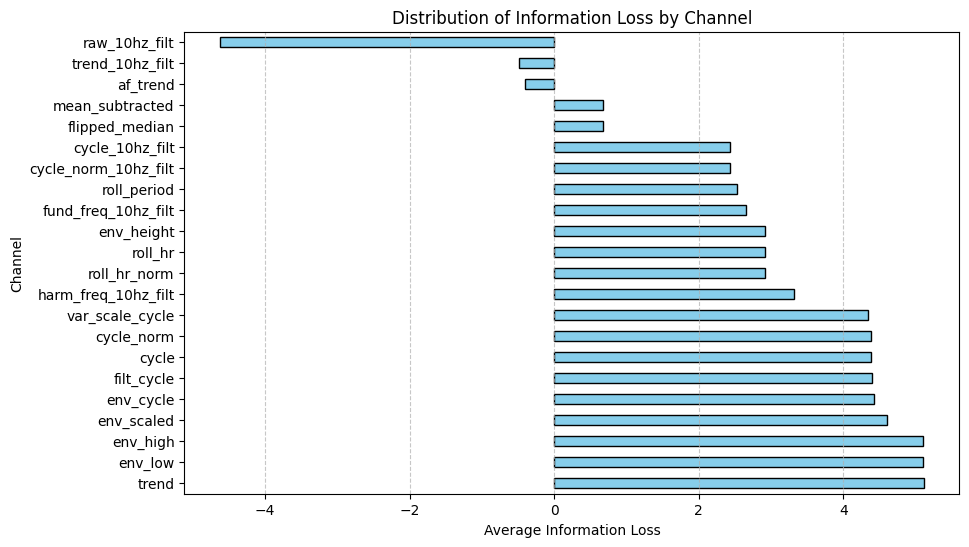

In [69]:
import matplotlib.pyplot as plt

def plot_info_loss_distribution(aggregated_loss):
    channel_loss = aggregated_loss.groupby('channel')['Information_Loss'].mean().sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    channel_loss.plot(kind='barh', color='skyblue', edgecolor='black')

    # Add labels and title
    plt.xlabel('Average Information Loss')
    plt.ylabel('Channel')
    plt.title('Distribution of Information Loss by Channel')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.show()

# Apply the plotting function to the aggregated loss data
plot_info_loss_distribution(aggregated_loss)
